In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import GridSearchCV

In [ ]:
# Load dataset
url = 'https://raw.githubusercontent.com/farrelrassya/teachingMLDL/refs/heads/main/02.%20Deep%20Learning/Dataset/income.csv'
df = pd.read_csv(url)

In [4]:
# Pembersihan data
# 1. Mengganti '?' dengan NaN
categorical_cols = ['workclass', 'occupation', 'native-country']
for col in categorical_cols:
    df[col] = df[col].replace('?', np.nan)

In [5]:
# 2. Imputasi kolom kategorikal dengan mode
for col in categorical_cols:
    mode_value = df[col].dropna().mode()[0]
    df[col].fillna(mode_value, inplace=True)

In [6]:
# 3. Membersihkan kolom income
df['income'] = df['income'].str.replace('.', '').str.strip()

In [7]:
# Mempersiapkan data untuk pemodelan
# Identifikasi kolom kategorikal dan numerikal
cat_cols = ['workclass', 'education', 'marital-status', 'occupation', 
            'relationship', 'race', 'sex', 'native-country']
num_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

In [11]:
# Membagi data menjadi fitur dan target
X = df.drop('income', axis=1)
y = df['income']

# Konversi target ke biner (0 untuk '<=50K' dan 1 untuk '>50K')
y = (y == '>50K').astype(int)

# Membagi data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
# Membuat pipeline preprocessing
# - OneHotEncoder untuk kolom kategorikal
# - StandardScaler untuk kolom numerikal
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ])

# Membuat pipeline model
dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

In [13]:
# Melatih model
dt_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'fnlwgt',
                                                   'education-num',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('classifier', DecisionTreeClassifier(random_state=42))])

In [ ]:
# Prediksi
y_pred = dt_pipeline.predict(X_test)

In [ ]:
# Evaluasi model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['<=50K', '>50K']))

auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
print("\nAUC/ROC  : ", auc)

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)


Accuracy: 0.8128

Classification Report:
              precision    recall  f1-score   support

       <=50K       0.88      0.87      0.88     11109
        >50K       0.61      0.63      0.62      3544

    accuracy                           0.81     14653
   macro avg       0.74      0.75      0.75     14653
weighted avg       0.81      0.81      0.81     14653


AUC/ROC  :  0.7500108076403591

Confusion Matrix:
[[9683 1426]
 [1317 2227]]


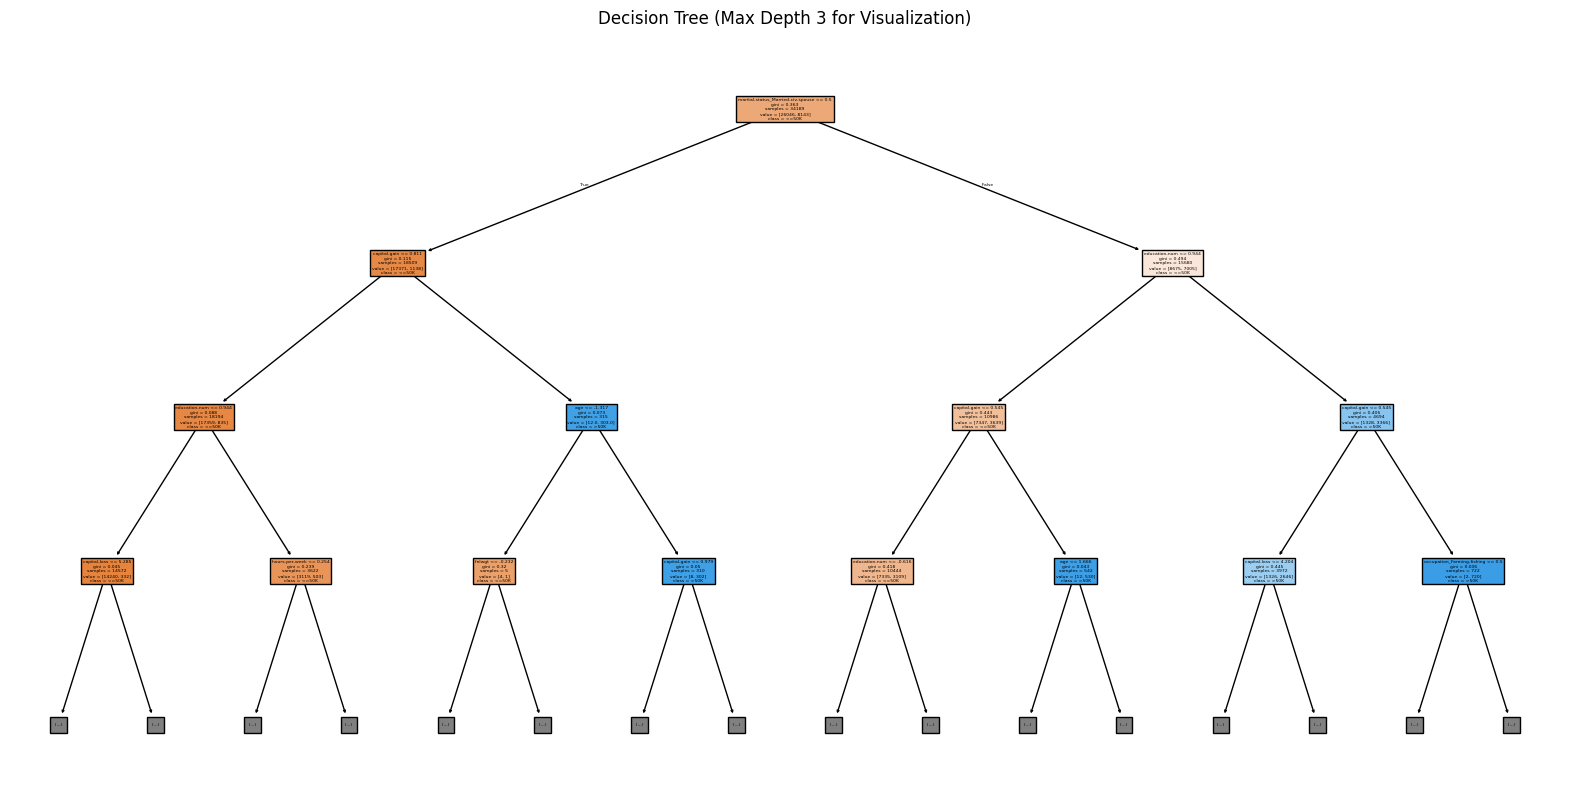

In [26]:
# Visualisasi Decision Tree (mengambil pohon dari pipeline)
dt_classifier = dt_pipeline.named_steps['classifier']
preprocessor = dt_pipeline.named_steps['preprocessor']

# Mendapatkan nama fitur setelah transformasi
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)
feature_names = list(num_cols) + list(ohe_feature_names)

# Plotting tree (hanya bagian atas dari pohon)
plt.figure(figsize=(20, 10))
tree.plot_tree(dt_classifier, 
               max_depth=3,  # Batasi kedalaman visual untuk keterbacaan
               feature_names=feature_names,
               class_names=['<=50K', '>50K'],
               filled=True)
plt.title('Decision Tree (Max Depth 3 for Visualization)')
plt.show()


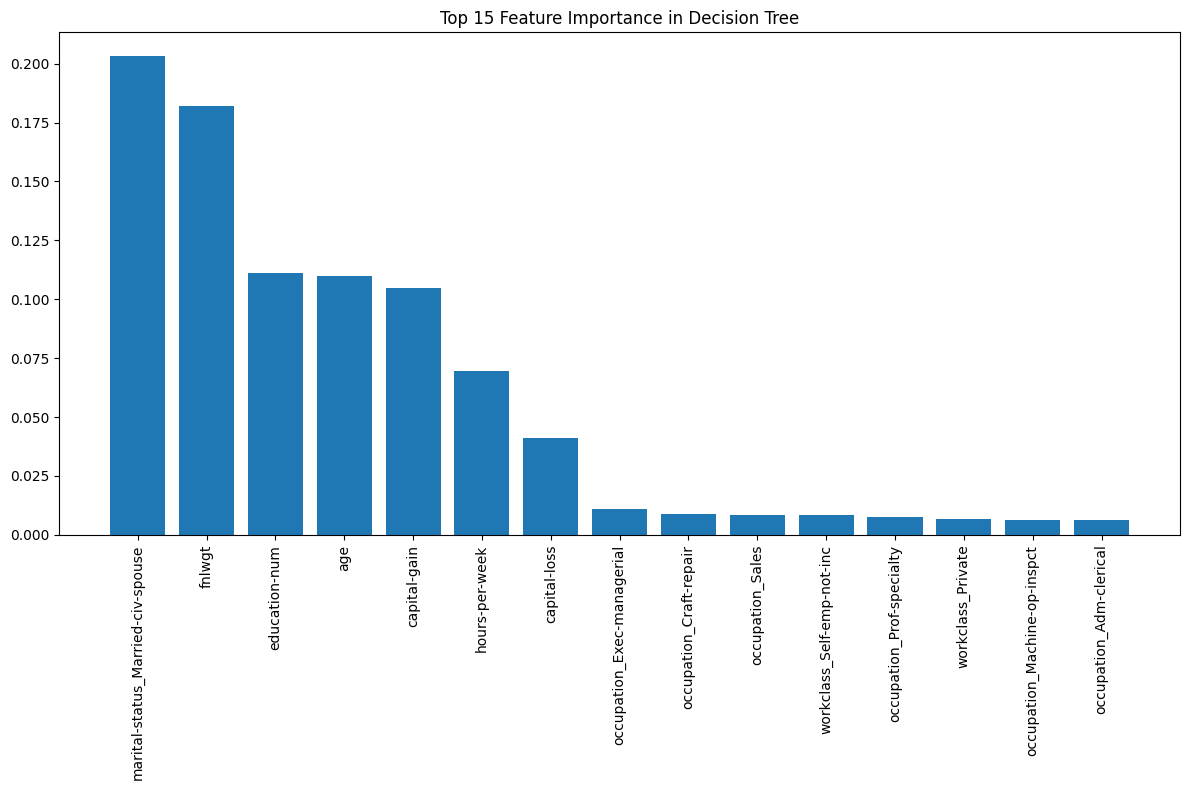

In [27]:
# Mencetak feature importance
feature_importance = dt_classifier.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]

plt.figure(figsize=(12, 8))
plt.bar(range(len(sorted_idx[:15])), feature_importance[sorted_idx[:15]])
plt.xticks(range(len(sorted_idx[:15])), [feature_names[i] for i in sorted_idx[:15]], rotation=90)
plt.title('Top 15 Feature Importance in Decision Tree')
plt.tight_layout()
plt.show()


In [28]:
# Hyperparameter tuning (opsional)
# Kita bisa melakukan grid search untuk menemukan parameter terbaik

param_grid = {
    'classifier__max_depth': [5, 10, 15, 20, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(dt_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("\nHasil Grid Search:")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")


Hasil Grid Search:
Best parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10}
Best cross-validation score: 0.8587


In [29]:
# Model dengan parameter terbaik
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

print("\nEvaluasi Model dengan Parameter Terbaik:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=['<=50K', '>50K']))

auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
print("AUC/ROC : ",auc)


Evaluasi Model dengan Parameter Terbaik:
Accuracy: 0.8589

Classification Report:
              precision    recall  f1-score   support

       <=50K       0.88      0.95      0.91     11109
        >50K       0.78      0.58      0.67      3544

    accuracy                           0.86     14653
   macro avg       0.83      0.77      0.79     14653
weighted avg       0.85      0.86      0.85     14653

AUC/ROC :  0.7500108076403591


## 1. Accuracy (Akurasi): 0.8589
Artinya: Model memprediksi benar sebanyak 85.89% dari seluruh data.

Cocok digunakan saat data seimbang, tapi kurang ideal jika data tidak seimbang.

Di sini, data tampak tidak seimbang (<=50K jauh lebih banyak dari >50K), jadi akurasi bisa menyesatkan.

## 2. Precision
<=50K: 0.88 → dari semua prediksi <=50K, 88% benar.

.>50K: 0.78 → dari semua prediksi >50K, hanya 78% benar.

Precision penting kalau kamu ingin meminimalkan false positive (contoh: tidak mau salah prediksi seseorang dapat >50K padahal tidak).

## 3. Recall
<=50K: 0.95 → hampir semua orang dengan pendapatan <=50K dikenali dengan baik.

.>50K: 0.58 → hanya 58% orang dengan pendapatan >50K yang berhasil dikenali model.

Kalau kamu ingin menangkap sebanyak mungkin orang dengan >50K (minimalkan false negative), recall ini penting. Di sini, recall untuk >50K masih cukup rendah.

## 4. F1-Score
Gabungan antara precision dan recall.

.>50K: 0.67 → menunjukkan model masih kurang bagus dalam mengenali kelompok ini.

Cocok digunakan kalau kamu ingin keseimbangan antara presisi dan recall.

## 5. AUC / ROC 
AUC menunjukkan kemampuan model membedakan antara kelas. Makin mendekati 1, makin bagus.

Nilai 0.75 berarti model cukup bagus membedakan antara orang yang berpenghasilan >50K dan <=50K.

Cocok sebagai metrik tambahan, apalagi untuk visualisasi dan threshold tuning.

## Kesimpulan
Dari penjelasan dan kasus di atas, dapat disimpulkan bahwa matriks evaluasi F1-score dan AUC/ROC merupakan matriks evaluasi yang paling relevan untuk difokuskan. Hal ini dikarenakan frekuensi kedua kelas tidak seimbang dan perlu adanya penyesuaian lebih lanjut agar nilai F1-score dan AUC/ROC bisa ditingkatkan.